In [8]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import math
import csv
import json

def to_seconds(time):
    return round(time, 0)

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

def clean_file_name(f):
    return f.replace(f'{os.getcwd()}/ready/', '').replace('.csv.pkl', '').replace('.', '')

In [9]:
mypath = os.getcwd() + '/ready'
files = [''.join([mypath, '/', f]) for f in listdir(mypath) if isfile(join(mypath, f)) ]

### Evaluating Sparsity

Readings are at roughly the second level. We will plot and extract data at that temporal resolution, this can always be altered if we get denser reading intervals

In [10]:
scam = np.load('/Users/lauren/marinetti/ready/SCam3_tt.csv.pkl', allow_pickle=True)
scam = np.squeeze(scam)

scam_s  = list(map(to_seconds, scam))

scam_s = list(map(lambda x: x - to_seconds(min(scam)), scam_s))

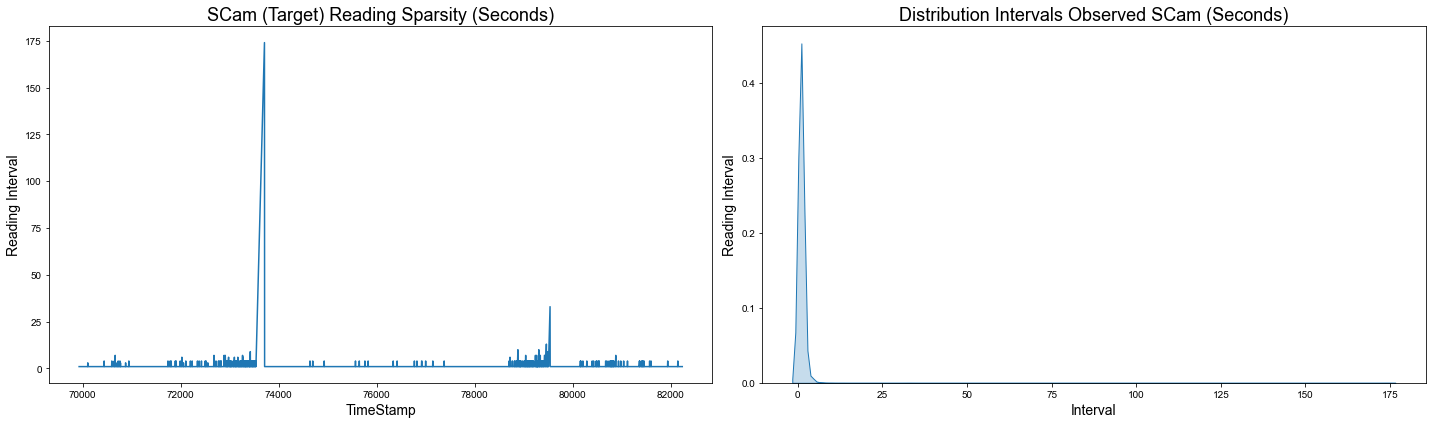

In [11]:
#load SCam Data
scam_diffs = np.diff(scam_s)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

ax1.plot(scam[1:], scam_diffs) 
ax1.set_title(label = "SCam (Target) Reading Sparsity (Seconds)", fontdict = { 'fontsize': 18})
ax1.set_ylabel("Reading Interval", fontdict = { 'fontsize': 14})
ax1.set_xlabel("TimeStamp", fontdict = { 'fontsize': 14})


sns.set_style('whitegrid')
p = sns.kdeplot(np.array(scam_diffs), bw_method=0.5, fill=True, ax=ax2)
p.set_title(label='Distribution Intervals Observed SCam (Seconds)', fontdict = { 'fontsize': 18})
p.set_ylabel("Reading Interval", fontdict = { 'fontsize': 14})
p.set_xlabel("Interval", fontdict = { 'fontsize': 14})

plt.tight_layout()

### ETL: ML-Ready Data
Create a dataframe for analysis and raw data for downstream ML models 

In [12]:
names = []
              
FLAT_NAMES = ['xCentroid', 'xrms', 'yCentroid', 'yrms', 'uCentroid', 'urms', 'vCentroid', 'vrms', 'Gaussian_Sum']

observations = []
files = [file for file in files if 'tt' not in file.replace('marinetti', '').lower()]
for file_name in files: 
    x = np.load(file_name, allow_pickle=True)
    if x.shape[0]: #some are 0
        if x.shape[1] > 1:
            flatten = np.split(x, x.shape[1], axis =1)
            for j, f in enumerate(flatten):
                expand_name = clean_file_name(file_name) + '_'+ FLAT_NAMES[j]
                names.append(expand_name)
                observations.append(f)
        else:
            names.append(clean_file_name(file_name))
            observations.append(x)
            
observations = np.concatenate(observations, axis = 1)

### Make DataFrame

Make the correct datetime intervals by doing a join on a dataframe with dense readings and the one constructed from the actual readings 

In [13]:
#there are likely bugs here but it's good enough for now
rx = list(range(0, int(max(scam_s))))
tf = pd.DataFrame({'year': [1970] * len(rx),
                   'month': [1] * len(rx),
                   'day': [1] * len(rx),
                   'seconds': len(rx)})
i = pd.date_range(0, periods=len(rx), freq='S')
left_df = pd.DataFrame(columns = names, index = i)

In [14]:
s = pd.to_datetime(scam_s, unit='s')
right_df = pd.DataFrame(observations, columns = names, index=s)

In [15]:
#pandas.merge_asof nifty thing if we want to do approximate matching
right_df.index.name = 'Time'
left_df.index.name = 'Time'

joined = right_df.join(left_df, how='right', rsuffix='Time')
joined  = joined.iloc[:, 0:48]

# Basic Visualization

#### Control Parameters

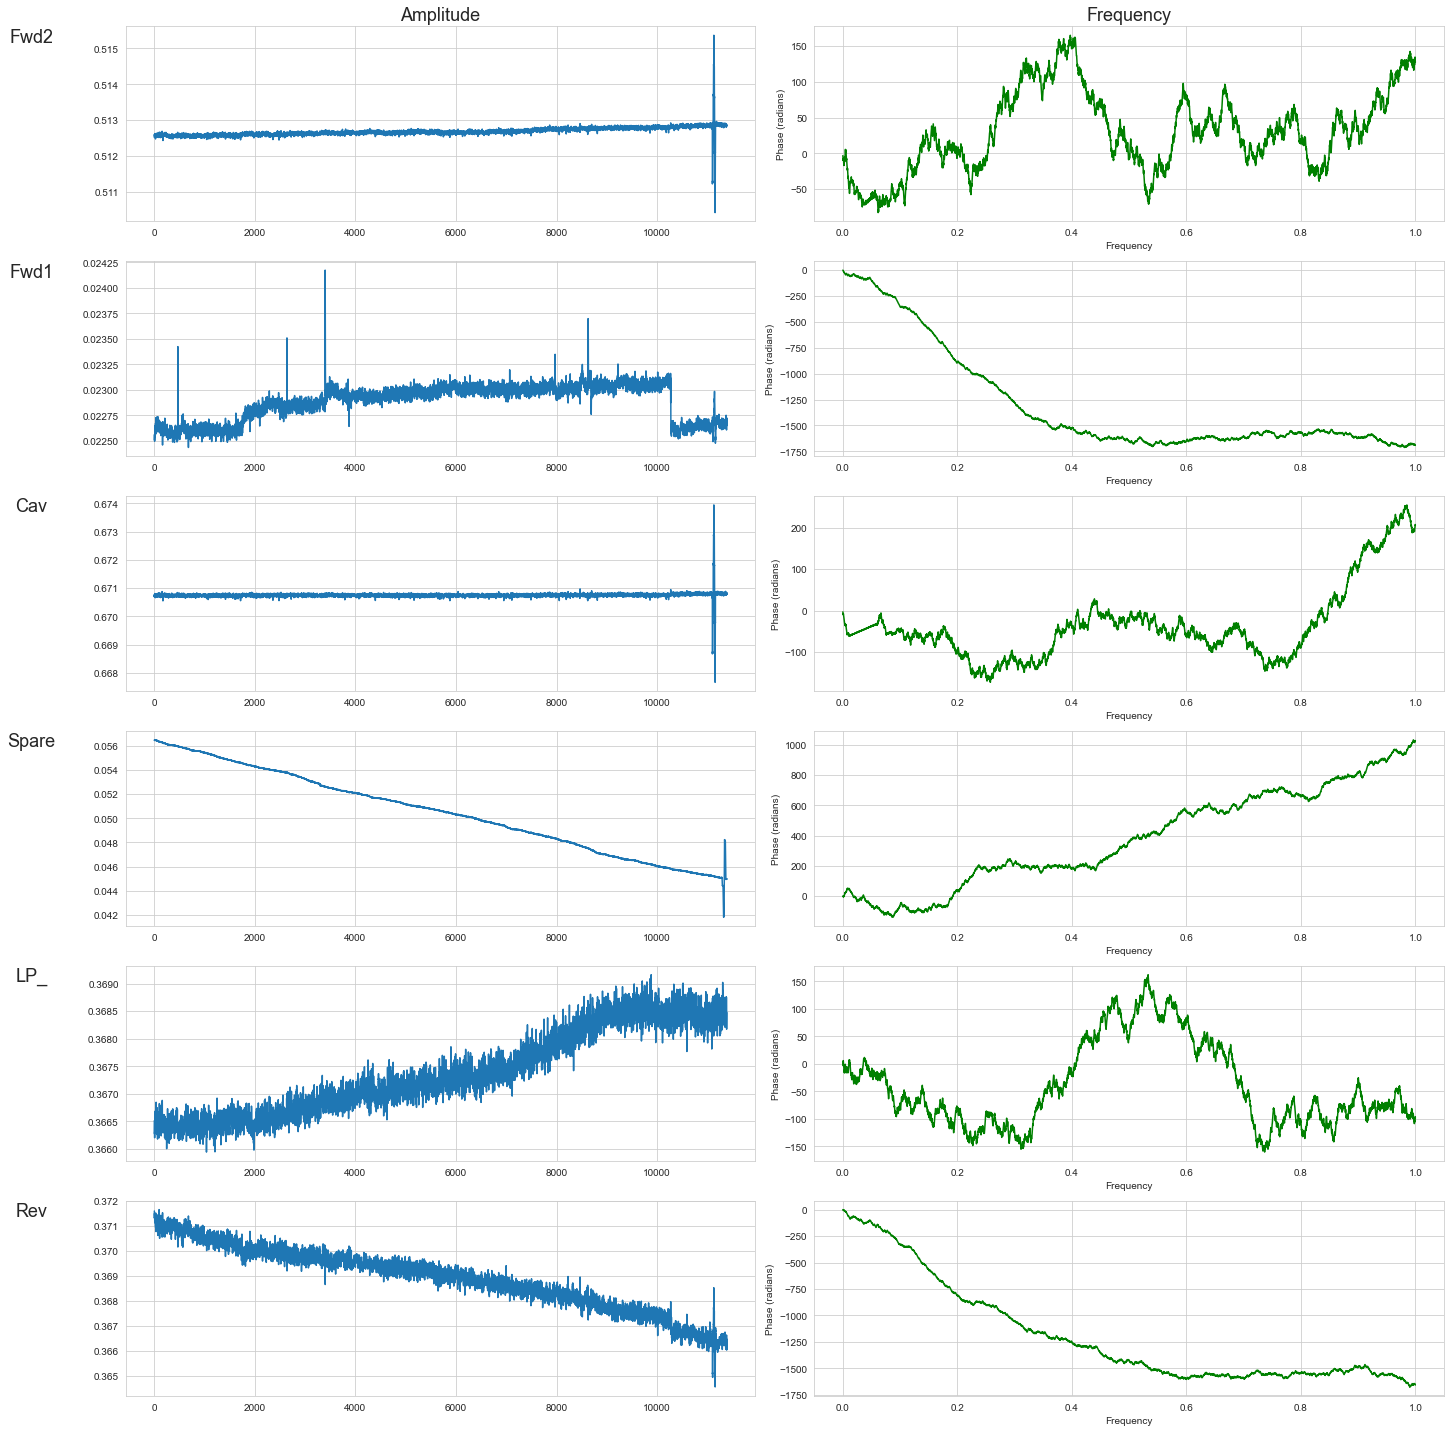

In [16]:
amp_keys = ['Fwd2Amp',  'Fwd1Amp', 'CavAmp', 'SpareAmp', 'LP_Amp','RevAmp']
phs_keys =  ['Fwd2Phs', 'Fwd1Phs', 'Cavphs', 'SparePhs',  'LP_Phase', 'Rev_Phs']

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,20), tight_layout=True)

for ax, col in zip(axes[0], ['Amplitude', 'Frequency']):
    ax.set_title(col,  fontdict = { 'fontsize': 18})

for ax, row in zip(axes[:,0], list(map(lambda x: x.replace('Amp', ''), amp_keys))):
    ax.set_ylabel(row, rotation=0,  fontdict = { 'fontsize': 18})
    ax.yaxis.set_label_coords(-0.15,0.9)

for e in range(0, len(amp_keys)):
    time = np.array(range(0, 11389))
    
    amp_key = amp_keys[e]
    amps = np.array(np.squeeze(joined[amp_key].dropna()))
    
    
    #transform to complex numbers
    phs_key = phs_keys[e]
    phs = np.array(np.squeeze(joined[phs_key].dropna()))
    phs = np.deg2rad(phs)

    axes[e, 0].plot(time, amps)
    
    axes[e, 1].phase_spectrum(phs, color ='green')

### LCam Data
#### Histogram Centroids

In [19]:
lcam_bg_loc_data = ['LCamGaussBG_xCentroid', 'LCamGaussBG_xrms',  'LCamGaussBG_yCentroid', 'LCamGaussBG_uCentroid', 'LCamGaussBG_vCentroid']
 
lcam_loc_data = ['LCamGauss_xCentroid', 'LCamGauss_xrms', 'LCamGauss_yCentroid', 'LCamGauss_uCentroid', 'LCamGauss_vCentroid']
    
# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
# joined[lcam_bg_loc_data + lcam_loc_data].plot(subplots=True, ax= axes)


def camera_plot(camera_type):
    f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
    for i, coord in enumerate(['x', 'y', 'u', 'v']):
        # Load an example dataset with long-form data
        mean_bg= np.array(np.squeeze(joined[[f'{camera_type}GaussBG_{coord}Centroid']].dropna()))
        std_bg = np.array(np.squeeze(joined[[f'{camera_type}GaussBG_{coord}rms']].dropna()))
        t = np.array(range(0, 11389))

        mean= np.array(np.squeeze(joined[[f'{camera_type}Gauss_{coord}Centroid']].dropna()))
        std = np.array(np.squeeze(joined[[f'{camera_type}Gauss_{coord}rms']].dropna()))
        t = np.array(range(0, 11389))


#         n_mean = mean - mean_bg
#         n_std = std - std_bg

        ax[i].plot(t[:100], mean[:100], label='X Centroid')
        ax[i].fill_between(t[:100], mean[:100] - std[:100], mean[:100] + std[:100], alpha=0.5)
       
    return ax 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

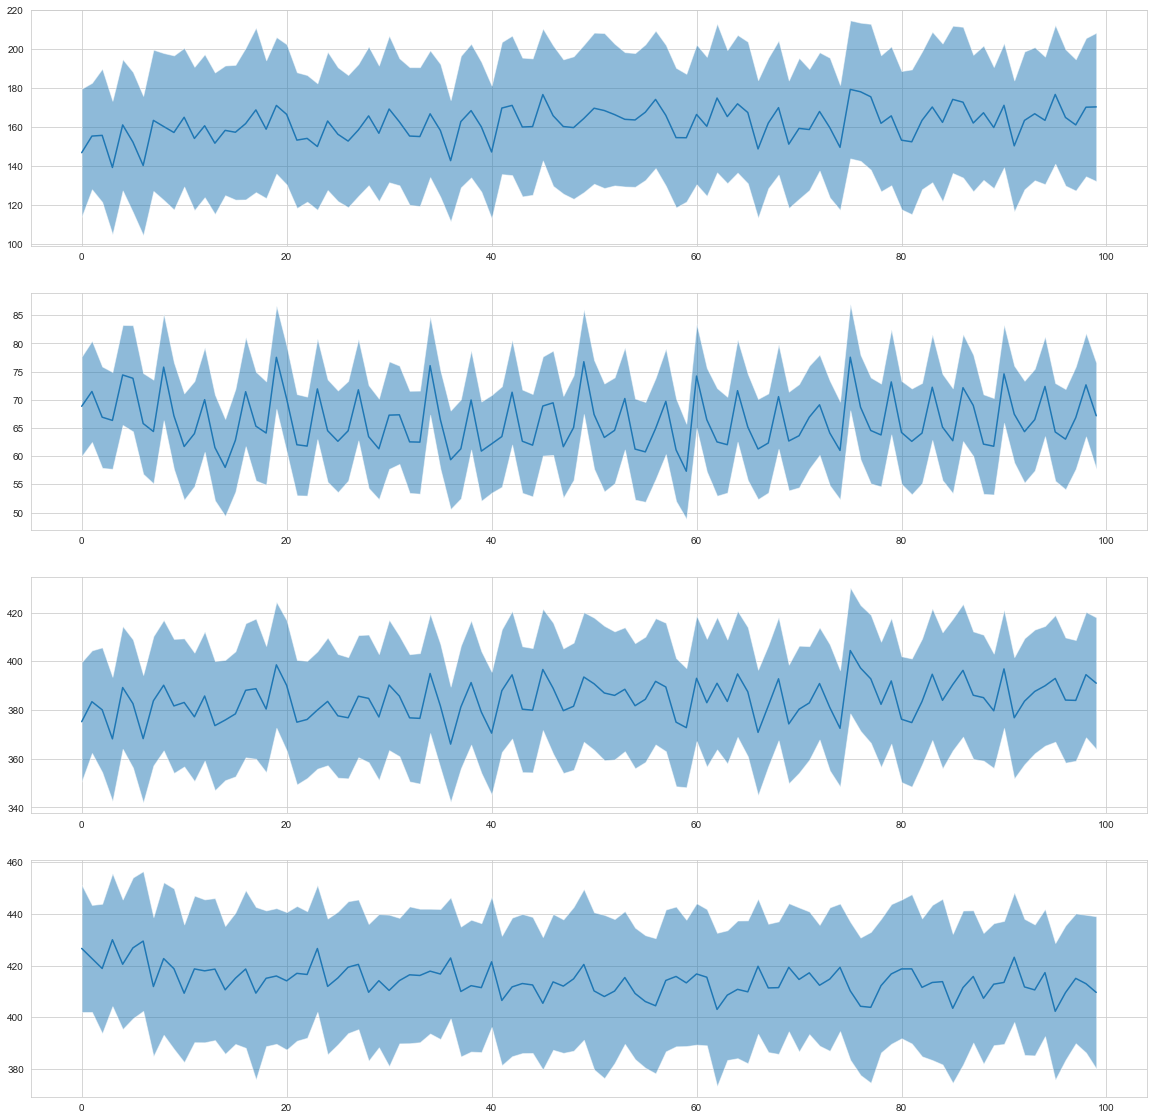

In [20]:
camera_plot("SCam3_")


#useful for v

In [21]:
joined.to_pickle('pickled_df_ALL.pk')

In [14]:
joined.head()

,Fwd1Amp,LCamGaussBG_xCentroid,LCamGaussBG_xrms,LCamGaussBG_yCentroid,LCamGaussBG_yrms,LCamGaussBG_uCentroid,LCamGaussBG_urms,LCamGaussBG_vCentroid,LCamGaussBG_vrms,LCamGaussBG_Gaussian_Sum,...,SCam3_Gauss_xrms,SCam3_Gauss_yCentroid,SCam3_Gauss_yrms,SCam3_Gauss_uCentroid,SCam3_Gauss_urms,SCam3_Gauss_vCentroid,SCam3_Gauss_vrms,SCam3_Gauss_Gaussian_Sum,LP_Amp,Fwd2Amp
Time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00,0.022508,32.003670,8.270485,42.817985,8.089002,43.040927,8.848505,46.787501,7.987521,235214.116828,...,32.891862,68.852859,8.837503,375.222468,24.502205,426.628428,24.546571,1.842505e+06,0.366276,0.512519
1970-01-01 00:00:01,0.022537,31.682232,7.919545,42.790500,8.070923,42.555308,8.244010,46.976442,7.834073,134689.852673,...,27.386855,71.485349,8.987038,383.426830,21.070552,422.756037,20.662912,8.265655e+05,0.366451,0.512598
1970-01-01 00:00:02,0.022541,32.003254,8.434171,42.783151,8.257484,43.060566,8.999335,46.862217,8.029195,271305.418341,...,34.278664,66.917990,8.998706,380.102540,25.626671,418.882018,24.991122,2.182978e+06,0.366502,0.512604
1970-01-01 00:00:03,0.022562,31.844320,8.549102,42.984730,8.491756,43.214291,9.033780,47.377427,8.326892,270607.890889,...,34.318775,66.345845,8.596570,368.181755,25.504587,429.979276,25.667503,2.136607e+06,0.366510,0.512576
1970-01-01 00:00:04,0.022517,31.892984,8.352428,42.924966,8.361304,43.355929,8.901612,47.063289,8.280108,279649.641176,...,33.752881,74.411032,8.878195,389.240224,25.194534,420.522658,25.024092,2.095492e+06,0.366518,0.512594
